In [33]:
%matplotlib inline

In [32]:
from selenium.webdriver.firefox.options import Options
from selenium.webdriver import FirefoxProfile
from selenium.webdriver.support.ui import WebDriverWait
from selenium.common.exceptions import TimeoutException
from selenium import webdriver
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from IPython.core.debugger import set_trace

import os, time, random
import pandas as pd
import json
import re
from datetime import datetime, timedelta, date
import requests
import traceback
import urllib.parse as urlparse
from urllib.parse import parse_qs, urlparse, urlencode, urlunparse, quote_plus
import hashlib
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
from shutil import copyfile


import cv2, base64
import numpy as np
from selenium.webdriver.remote.webelement import WebElement
from selenium.webdriver.common.action_chains import ActionChains
import math

In [34]:
DIRECTORY = "/home/keshev/Repos"
PROJECT = "AI_Scraper"

## Selenium Helper Functions

In [242]:
def initialize_browser(headless=False):
    with open(f"{DIRECTORY}/{PROJECT}/config/proxies.json", "r") as f:
        proxy_dict = json.load(f)
        proxy_list = proxy_dict["proxies"]
    #options = Options()

    #if self._worker_settings.fox_options['headless']:
    #	options.add_argument('--headless')
    # 
    profile = FirefoxProfile()
    #profile.set_preference("network.proxy.type", 1)
    #profile.set_preference("network.proxy.http", ip)
    #profile.set_preference("network.proxy.http_port", port)

    #profile.set_preference("network.proxy.ssl", ip)
    #profile.set_preference("network.proxy.ssl_port", port)

    options = Options()
    options.headless = headless
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-extensions')
    browser = webdriver.Firefox(firefox_profile=profile, options=options)
    #browser = webdriver.Firefox(firefox_profile=profile)

    return browser

def handle_init_row(site_name, site_module, scrape_id, sample_url):
    save_folder = f"{base_dir}/page_ai_init/init_page_output/{scrape_id}"
    if not os.path.exists(save_folder):
        os.mkdir(save_folder)
        
    browser = initialize_browser(headless=True)
    browser.get(sample_url)
    time.sleep(1)
    browser.execute_script(("window.scrollBy(0,document.body.scrollHeight);"))
    
    with open(f'{save_folder}/sample_page_latest.html', 'w') as f:
        html = browser.execute_script("return document.getElementsByTagName('html')[0].innerHTML")
        f.write(browser.page_source)

    with open(f'{save_folder}/sample_page_{str(date.today()).replace("-","_") }.html', 'w') as f:
        html = browser.execute_script("return document.getElementsByTagName('html')[0].innerHTML")
        f.write(browser.page_source)
        
    print(f"SAVING SAMPLE PAGE SOURCE FOR {site_name} {site_module} with SCRAPEID: {scrape_id}")

## Screenshot Helper Functions

In [36]:
def scroll_shim(passed_in_driver, element):
    x = element.location['x']
    y = element.location['y']
    scroll_by_coord = 'window.scrollTo(%s,%s);' % (
        x,
        y
    )
    scroll_nav_out_of_way = 'window.scrollBy(0, -120);'
    passed_in_driver.execute_script(scroll_by_coord)
    passed_in_driver.execute_script(scroll_nav_out_of_way)
    
def img_from_b64(encoded_data):
   #encoded_data = uri.split(',')[1]
   nparr = np.fromstring(base64.b64decode(encoded_data), np.uint8)
   img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
   return img

def visualize_image(img_array): 
    fig2 = plt.figure(figsize = (20,20)) # create a 5 x 5 figure 
    ax3 = fig2.add_subplot(111)
    ax3.imshow(img_array, interpolation='none')

In [389]:
def execute_codedata_function(browser, element, bounding_box): 
    #NOTES
    #save "visible page source" by iterating through all the elements WebElement.isDisplayed()
    #check if the element I want is displayed
    #is the element on screen? (does that actually matter so long as I can find it in the page source?)
        #Doesn't matter - metadata grab is actually just going to operate on the rendered page script
    
    ############################################################################
    #Let's keep it simple for now. One algorith running on the full page source#
    ############################################################################
    
    #save the element string
    #save the 
    pass

def execute_screenshot_function(browser, element, bounding_box): 
    ####can grab whatever I need out of the full page source later
    try:
        current_y = browser.execute_script("var doc = document.documentElement;return (window.pageYOffset || doc.scrollTop)  - (doc.clientTop || 0)")
        current_y = browser.execute_script("return window.scrollY;")

        #top of the browser window
        window_height = browser.execute_script("return window.innerHeight")
        bottom = current_y + browser.execute_script("return window.innerHeight")
        #bottom of the browser window

        scroll = browser.execute_script("return window.scrollY;")
        src_base64 = browser.get_screenshot_as_base64()
        full_screen_img = img_from_b64(src_base64)
        bounding_box_img = full_screen_img.copy()
        top_rel_to_viewport =  math.floor(bounding_box["top"] - scroll)

        #scr_img = Image(blob=scr_png)
        if current_y < bounding_box["top"] and (bottom) > (bounding_box["top"] + bounding_box["height"]):
            #bounding_box is in frame

            x1,y1,x2,y2 = bounding_box["left"],\
                          top_rel_to_viewport,\
                          bounding_box["left"] + bounding_box["width"],\
                          top_rel_to_viewport + bounding_box["height"]
            cv2.rectangle(bounding_box_img,(x1,y1),(x2,y2),(0,255,0),6)
            match_type = "full"
#         elif current_y > (bounding_box["top"] - window_height) and current_y < bounding_box["top"]:
#             #bounding box is partially in frame cut off at the bottom
#             x1,y1,x2,y2 = bounding_box["left"],\
#                           top_rel_to_viewport,\
#                           bounding_box["left"] + bounding_box["width"],\
#                           bottom
#             cv2.rectangle(bounding_box_img,(x1,y1),(x2,y2),(255,0,0),1)
#             match_type = "partial"
#         elif current_y < (bounding_box["top"] + bounding_box["height"]) and current_y > bounding_box["top"]:
#             #bounding box is partially in frame cut off at the top
#             x1,y1,x2,y2 = bounding_box["left"],\
#                   math.floor(current_y),\
#                   bounding_box["left"] + bounding_box["width"],\
#                   top_rel_to_viewport + bounding_box["height"]
#             cv2.rectangle(bounding_box_img,(x1,y1),(x2,y2),(0,255,0),6)
#             match_type = "partial"
        else: 
            #bounding box is not in frame    
            match_type = "none"
            x1,y1,x2,y2 = -1,-1,-1,-1

        metadata_dictionary = {'bounding_box':[(x1,y1),(x2,y2)],
                               'window_top_px':current_y,
                               'window_height':window_height, 
                               'match_type':match_type}
        #save a 'label' file with:
            #bounding box relative to the viewport
            #whether the element is visible / partially visible / not visible
            #use WebElement.isDisplayed()

        #take a screenshot
        #save the screeenshot

        return full_screen_img, bounding_box_img, metadata_dictionary
    
    except Exception as e: 
        print(e)
        set_trace()

def get_element_bounding_box(browser, element: WebElement):
    
    #only handles the vertical scroll case
    scrollY = browser.execute_script("return window.scrollY;")
    scrollX = browser.execute_script("return window.scrollX")
    
    #scroll to the element
    scroll_shim(browser, element)
    
    #move the cursor to the element
    
    #ActionChains(browser).move_to_element(element).perform()  # focus

    
    #this ended up being more complicated than I originally thought
    #because <a> attributes are inline elements they often don't have a specific height. 
    #Everything that falls under the a element is clickable though so what I can do is iterate through all the children and 
    #make sure my bounding box is the one that covers everything
    
    #NOTE : may need to add in iteration through children recursively
    box_and_children = browser.execute_script("""var attr_children = [].slice.call(arguments[0].children);
                                                 attr_children.push(arguments[0]);
                                                 return attr_children""", element)

    boxes = []
    all_boxes = []
    for b_or_c in box_and_children:
        box = browser.execute_script("return arguments[0].getBoundingClientRect()", b_or_c)
        if box["width"] != 0 or box["height"] != 0:
            boxes.append(box)
        all_boxes.append(box)
    
    if len(boxes)==0: 
        boxes = all_boxes
        
    
    #biggest_box_lol = max(boxes, key=lambda x: x["width"])
    
    
    window_scroll_for_element_y = browser.execute_script("return window.scrollY;")
    window_scroll_for_element_x = browser.execute_script("return window.scrollX;")

    top = min([x["top"] for x in boxes]) + window_scroll_for_element_y
    left = min([x["left"] for x in boxes]) + window_scroll_for_element_x
#     top = biggest_box_lol["top"] + window_scroll_for_element_y
#     left = biggest_box_lol["left"] + window_scroll_for_element_x
    h = max([x["height"] for x in boxes])
    w = max([x["width"] for x in boxes])

    
#    h = biggest_box_lol["height"]
#    w = biggest_box_lol["width"]
    
    

    #get all the bounding box information
    #x = element.location["x"]
    #y = element.location["y"]
    #y_rel_to_viewport = y - scroll
    
#     w = element.size["width"]
#     h = element.size["height"]
    
    bounding_box = {"left":math.floor(left),\
                    "top":math.floor(top),\
                    "width":math.ceil(w),\
                    "height":math.ceil(h)\
                   }
    
    #set the browser back to where it was before
    browser.execute_script(f"window.scrollTo({scrollX}, {scrollY});")
    return bounding_box
    #return bounding_box
    
def get_element_screenshot(element: WebElement) -> bytes:    
    
    driver = element._parent
    ActionChains(driver).move_to_element(element).perform()  # focus
    src_base64 = driver.get_screenshot_as_base64()
    scr_png = b64decode(src_base64)
    scr_img = Image(blob=scr_png)
    #TODO better structure these 2 functions so they work better independently
    scroll = browser.execute_script("return window.scrollY;")

    bounding_box = get_element_bounding_box(element, scroll)
    set_trace()        

    scr_img.crop(**bounding_box)
#     scr_img.crop(
#         left=math.floor(x),
#         top=math.floor(y),
#         width=math.ceil(w),
#         height=math.ceil(h),
#     )
    return scr_img.make_blob(), bounding_box

def write_all_candidate_samples(browser, scrape_id, candidates): 
    """
        For a given URL write the necessary files for all the candidates assessed as possible attributes
        create their local save paths, then return the compiled metadata and its corresponding save path
        for post processing
    """
    
    
    base_dir = f"/home/keshev/Projects/ai_scraper/page_ai_init/init_page_output/{scrape_id}/screenshots"
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
        
    url_key = hashlib.md5(browser.current_url.encode("utf-8")).hexdigest()
    url_dir = f"{base_dir}/{url_key}"
    
    if not os.path.exists(url_dir):
        os.mkdir(url_dir)
    
    full_browser_metadata = {"scrape_id":scrape_id,"url_key":url_key, "url":browser.current_url, "candidates":[]}
    
    for candidate_key, candidate_info in candidates.items(): 
        metadata = create_single_candidate_url_train_data(browser, scrape_id, candidate_key, candidate_info)
        #metadata["is_correct_candidate"] = candidate_info["is_correct_candidate"]
        full_browser_metadata["candidates"].append(metadata)
        
    return full_browser_metadata, url_dir
#     with open(f"{url_dir}/{url_key}_full__metadata.json", "w") as f: 
#         json.dump(full_browser_metadata, fp = f, indent = 2)
        
def create_single_candidate_url_train_data(browser, scrape_id, candidate_key, candidate_info): 
    #make all the directories
    base_dir = f"/home/keshev/Projects/ai_scraper/page_ai_init/init_page_output/{scrape_id}/screenshots"
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
        
    url_key = hashlib.md5(browser.current_url.encode("utf-8")).hexdigest()
    url_dir = f"{base_dir}/{url_key}"
    
    if not os.path.exists(url_dir):
        os.mkdir(url_dir)
        
    #psource_unique_directory_key = hashlib.md5((candidate_key + url_key).encode("utf-8")).hexdigest()
    candidate_save_path = candidate_info["local_save_path"]
    #psource_unique_directory_path = f"{url_dir}/{psource_unique_directory_key}"
    psource_unique_directory_path = f"{url_dir}/{candidate_save_path}"
    if not os.path.exists(psource_unique_directory_path):
        os.mkdir(psource_unique_directory_path)
    
    element = browser.find_element_by_xpath(candidate_info["xpath"])
    bounding_box = generate_sliding_window_data(browser, element, psource_unique_directory_path)
    metadata = {"bounding_box":bounding_box, 
                "candidate_key":candidate_key,
                "scrape_id":scrape_id,
                "candidate_info":candidate_info,
                "url":browser.current_url, 
                "scrape_time":str(datetime.now()),
                "unique_identifier":hashlib.md5((candidate_key + browser.current_url).encode("utf-8")).hexdigest()
               }
    
    
    with open(f"{psource_unique_directory_path}/{candidate_save_path}_metadata.json", "w") as f: 
        json.dump(metadata, fp = f, indent = 2)
        
    return metadata
#     bounding_box_dir = f"{sub_directory_path}/drawn_bounding_box"
#     cropped_img_dir = f"{sub_directory_path}/cropped_image_dir"
#     if not os.path.exists(bounding_box_dir):
#         os.mkdir(bounding_box_dir)
#     if not os.path.exists(cropped_img_dir):
#         os.mkdir(cropped_img_dir)
    
#     #make all the directories

#         fname = hashlib.md5(element_xpath.encode("utf-8")).hexdigest()
#         entry = {"file_key":fname,\
#                  "file_path":f"{cropped_img_dir}/{fname}/.png",\
#                  "bounding_box":bounding_box,\
#                  "drawn_bounding_box_filepath":f"{bounding_box_dir}/{fname}/.png",\
#                  "levels_up":levels_up, \
#                  "element_xpath":element_xpath}
#     output_metadata_dictionary = {candidate_key:{sub_directory_key:metadata_dictionary}}
#     return output_metadata_dictionary
        

def generate_sliding_window_data(browser, element, single_psource_save_path):
    #For a given webpage that browser is currently on
    #We have isolated element as our pagination element
    #We're going to then save that in the save path where for each candidate + url combo
    #we have our own folder
    '''Directory looks like this:
        amzn-best-sellers
            candidate
                candidate + url
                    screenshots
                        scroll_at_y1_metadata_file
                        scroll_at_y1_screenshot
                        scroll_at_y1_bounding_box_screenshot
                        scroll_at_y2_metadata_file
                        scroll_at_y2_screenshot
                        scroll_at_y2_bounding_box_screenshot'''
        
    #####get the bounding box 
    bounding_box = get_element_bounding_box(browser, element)
    
    bounding_box_viewport = bounding_box.copy()
    #scroll to the top
    
    height = browser.execute_script("return document.body.scrollHeight")
    window_height = browser.execute_script("return window.innerHeight")
    #Note standardize window height to avoid normalization later? 
    #Maybe but probably have to do it later anyway
    
    #scroll to the top
    browser.execute_script("window.scrollTo(0,0)")
    current_y = 0
    
    window_image_list = []
    bounding_box_image_list = []
    #autodetermine step size based on browser window height
    step_size_factor = 0.25
    step_size =math.floor(step_size_factor*window_height)
    slice_index = 0
    should_break = False
    while (current_y < height) and not should_break: 

        #while condition sets when to stop
        
        scroll = browser.execute_script("return window.scrollY;")

        #if condition handles the last acceptable range without throwing the scroll too far error
        if (current_y + window_height)>=height:
            #scroll up (current_y + window_height - height)
            #browser.execute_script(f"window.scrollBy(0,{-1*(current_y + window_height - height)})");
            
            #NOTE the last screenshot
            slice_index = math.floor((1 - step_size_factor)*window_height + current_y - scroll)
            #current_y = height
            should_break = True
            
            ###



        
        y_rel_to_viewport = bounding_box["top"] - scroll        
        #y_rel_to_viewport = y - scroll
        bounding_box_viewport["top"] = math.floor(y_rel_to_viewport)
        
        #top = document.execute_script("return (window.pageYOffset || doc.scrollTop)  - (doc.clientTop || 0)")";

        #TODO NEXT take the window screenshot, add the bounding box in after
        window_screenshot, bounding_box_screenshot, metadata_dictionary = execute_screenshot_function(browser, element, bounding_box)
        window_image_list.append(window_screenshot[slice_index:])
        bounding_box_image_list.append(bounding_box_screenshot[slice_index:])
        
        

#         with open(metadata_save_path, "w") as metadata_file: 
#             json.dump(metadata_dictionary, metadata_file,indent=1)

        #TODO evalutate image and baseline psource model
        #TODO implement the execute
        #execute_codedata_function(browser, element, bounding_box_viewport)
        #current_y += step_size
        browser.execute_script(f"window.scrollBy(0,{step_size})");
        current_y = browser.execute_script("return window.scrollY;")

        slice_index = math.floor((1 - step_size_factor)*window_height)
        height = browser.execute_script("return document.body.scrollHeight")

        
    full_browser_image = np.concatenate(window_image_list, axis=0)
    full_bounding_box_image = np.concatenate(bounding_box_image_list, axis=0)
    
    window_save_path = f"{single_psource_save_path}/window_screenshot.png"
    bounding_box_save_path = f"{single_psource_save_path}/bounding_box_screenshot.png"
    metadata_save_path = f"{single_psource_save_path}/scroll_at_{current_y}_single_screen_metadata.json" 
    
    cv2.imwrite(window_save_path, full_browser_image)
    cv2.imwrite(bounding_box_save_path, full_bounding_box_image)
    
    return bounding_box


In [236]:
scroll_shim(browser, browser.find_element_by_xpath('/html/body/div[5]/div[3]/div/div[2]/div[2]/div[4]/ul/li[8]/a'))

In [237]:
element = browser.find_element_by_xpath('/html/body/div[5]/div[3]/div/div[2]/div[2]/div[4]/ul/li[8]/a')

In [ ]:
def scroll_shim(passed_in_driver, element):
    x = element.location['x']
    y = element.location['y']
    scroll_by_coord = 'window.scrollTo(%s,%s);' % (
        x,
        y
    )
    scroll_nav_out_of_way = 'window.scrollBy(0, -120);'
    passed_in_driver.execute_script(scroll_by_coord)
    passed_in_driver.execute_script(scroll_nav_out_of_way)

In [161]:
PROJECT_DIR = "/home/keshev/Projects/ai_scraper/"

In [90]:
browser = initialize_browser() 

In [11]:
base_dir = "/home/keshev/Projects/ai_scraper/"

In [335]:
def identify_correct_pagination_candidate(metadata): 
    #the right most pagination element is probably the right one
    correct_candidate = max(metadata["candidates"], key=lambda x:x["bounding_box"]["left"])
    return correct_candidate

def create_best_guess_traindata(metadata, url_save_path):
    correct_element_metadata = identify_correct_pagination_candidate(metadata)
    element_local_location = f"{url_save_path}/{correct_element_metadata['candidate_info']['local_save_path']}"
    
    DATA_SAVE_DIR = f"{PROJECT_DIR}/ALL_DATA"
    bounding_path = f"{element_local_location}/bounding_box_screenshot.png"
    window_screenshot_path = f"{element_local_location}/window_screenshot.png"

    if not os.path.exists(DATA_SAVE_DIR):
        os.mkdir(DATA_SAVE_DIR)
    
    BB_DIR = f"{DATA_SAVE_DIR}/bounding_box_data"
    TRAIN_DIR = f"{DATA_SAVE_DIR}/train_data"
    LABEL_DIR = f"{DATA_SAVE_DIR}/metadata"

    if not os.path.exists(BB_DIR):
        os.mkdir(BB_DIR)
    
    if not os.path.exists(TRAIN_DIR):
        os.mkdir(TRAIN_DIR)
        
    if not os.path.exists(LABEL_DIR):
        os.mkdir(LABEL_DIR)
        
    url_save = hashlib.md5(correct_element_metadata["url"].encode("utf-8")).hexdigest()
    new_bb_path = f"{BB_DIR}/{url_save}.png"
    new_screenshot_path = f"{TRAIN_DIR}/{url_save}.png"
    metadata_path = f"{LABEL_DIR}/{url_save}.json"
        
    copyfile(bounding_path, new_bb_path)
    copyfile(window_screenshot_path, new_screenshot_path)
    with open(metadata_path, "w") as md_f:
        json.dump(metadata, md_f, indent=2)
    

In [223]:
p_finder = PaginationFinder()
candidates = p_finder.find_pagination_attributes(BeautifulSoup(browser.page_source))

In [277]:
soup = BeautifulSoup(browser.page_source, "html.parser")

In [310]:
candidates

{'77e0aec64cfea4b29c65f9d0a7929f46': {'element_attributes': {'href': '/toronto/3-bedroom-for-rent?property-type=Apartment&property-type=House&rent-min=0&rent-max=4000&p=2'},
  'xpath': '/html/body/div[5]/div[3]/div/div[2]/div[2]/div[4]/ul/li[4]/a',
  'element_text': '\n\n\n\n\n\n\n\n\n\n\n\n\n\n1\n\n\n\n\n2\n\n\n\n\n3\n\n\n\n\n4\n\n\n\n\n5\n\n\n\n\n\n\n\n\n\n\n\n\n\n',
  'local_save_path': '0_element'},
 'f5e71bd47012b6007da01b0087dae339': {'element_attributes': {'href': '/toronto/3-bedroom-for-rent?property-type=Apartment&property-type=House&rent-min=0&rent-max=4000&p=3'},
  'xpath': '/html/body/div[5]/div[3]/div/div[2]/div[2]/div[4]/ul/li[5]/a',
  'element_text': '\n\n\n\n\n\n\n\n\n\n\n\n\n\n1\n\n\n\n\n2\n\n\n\n\n3\n\n\n\n\n4\n\n\n\n\n5\n\n\n\n\n\n\n\n\n\n\n\n\n\n',
  'local_save_path': '1_element'},
 '1ebd1b4c2191bd880f6c1ca9045f4e4f': {'element_attributes': {'href': '/toronto/3-bedroom-for-rent?property-type=Apartment&property-type=House&rent-min=0&rent-max=4000&p=4'},
  'xpath': '

In [384]:
initialization_samples

,site_name,site_module,scrape_id,browser_size,sample_url
0,amazon,best_sellers,amzn_best_sellers,NaN,https://www.amazon.ca/Best-Sellers-Home-Kitche...
1,amazon,category,amzn_category,NaN,https://www.amazon.ca/b/ref=s9_acss_bw_cg_home...
2,indeed,jobs,indeed_jobs,NaN,https://www.indeed.ca/jobs?q=Data+Scientist&l=...
3,zumper,toronto,zumper_toronto,NaN,https://www.zumper.com/apartments-for-rent/tor...
4,torontorentals,boiiis,toronto_rentals,600.0,https://www.torontorentals.com/toronto/3-bedro...
5,point2homes,toronto,point_2_homes_toronto,600.0,https://www.point2homes.com/CA/Rental-Properti...
6,eventbrite,vancouver,eventbrite_vancouver,NaN,https://www.eventbrite.ca/d/canada--vancouver/...
7,zillow,zillow_boiiis,zillow_boiis,600.0,https://www.zillow.com/toronto-on/rent-townhom...


In [390]:
initialization_samples = pd.read_csv("/home//keshev/Projects/ai_scraper/page_ai_init/sample_urls/sample_urls_latest.csv")[6:]

p_finder = PaginationFinder()

for i,row in initialization_samples.iterrows():
    browser = initialize_browser(headless=False)
    if not pd.isnull(row["browser_size"]): 
        window_height = browser.execute_script("return window.innerHeight")
        browser.set_window_size(row["browser_size"], window_height)

    sample_url = row["sample_url"]
    scrape_id = row["scrape_id"]
    if not os.path.exists(save_folder):
        os.mkdir(save_folder)
        
    browser.get(sample_url)
    time.sleep(1)
    browser.execute_script(("window.scrollBy(0,document.body.scrollHeight);"))
    candidates = p_finder.find_pagination_attributes(BeautifulSoup(browser.page_source))
    write_all_candidate_samples(browser, scrape_id, candidates)
    metadata, url_save_path = write_all_candidate_samples(browser, scrape_id, candidates)
    create_best_guess_traindata(metadata, url_save_path)
    #     handle_init_row(**row.to_dict())

    browser.quit()
    

<ipython-input-36-a8c4e27522ff>:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(base64.b64decode(encoded_data), np.uint8)
<ipython-input-36-a8c4e27522ff>:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(base64.b64decode(encoded_data), np.uint8)


In [79]:
scrape_id = "amzn_category"
row = initialization_samples.loc[1]
save_folder = f"{base_dir}/page_ai_init/init_page_output/{scrape_id}"
sample_url = row["sample_url"]
if not os.path.exists(save_folder):
    os.mkdir(save_folder)

browser.get(sample_url)
time.sleep(1)
browser.execute_script(("window.scrollBy(0,document.body.scrollHeight);"))
candidates = p_finder.find_pagination_attributes(BeautifulSoup(browser.page_source))


In [60]:
height = browser.execute_script("return document.body.scrollHeight")

In [103]:
initialization_samples

,site_name,site_module,scrape_id,sample_url
0,amazon,best_sellers,amzn_best_sellers,https://www.amazon.ca/Best-Sellers-Home-Kitche...
1,amazon,category,amzn_category,https://www.amazon.ca/b/ref=s9_acss_bw_cg_home...
2,indeed,jobs,indeed_jobs,https://www.indeed.ca/jobs?q=Data+Scientist&l=...


In [314]:
candidate_key = list(candidates.keys())[4]
candidate_info = candidates[candidate_key]

In [315]:
candidate = browser.find_element_by_xpath(candidates[candidate_key]["xpath"])

In [329]:
bounding_box = get_element_bounding_box(browser, candidate)

In [330]:
bounding_box

{'left': 501, 'top': 120, 'width': 71, 'height': 50}

In [333]:
full,bb,meta = execute_screenshot_function(browser, candidate, bounding_box)

WebDriverException: Message: Failed to decode response from marionette


In [324]:
meta

{'bounding_box': [(0, 274), (71, 324)],
 'window_top_px': 3251,
 'window_height': 799,
 'match_type': 'full'}

In [114]:
full.shape, browser.execute_script("return window.innerHeight")


((873, 1280, 3), 873)

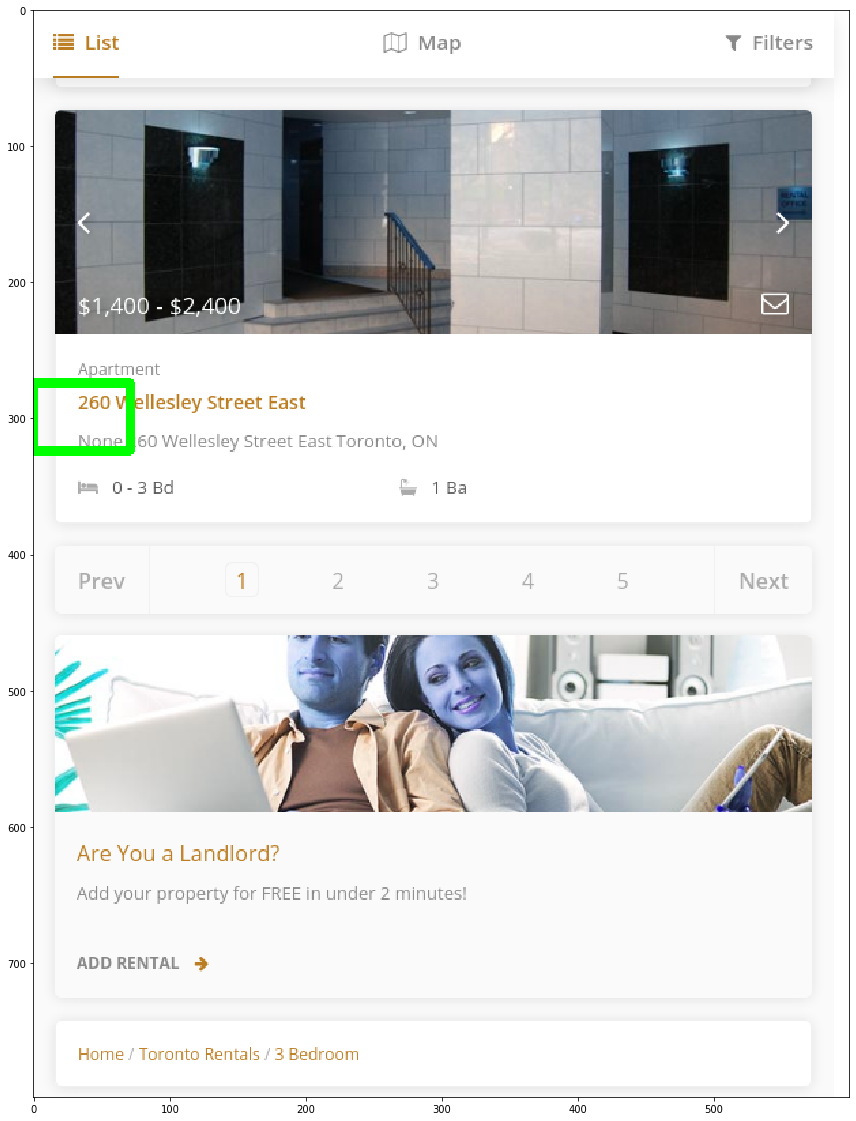

In [325]:
visualize_image(bb)

In [54]:


####TODO Next fix the scroll up and re-screenshot bug 
####TODO NEXT X4 get for other urls


#think about running the inference on just one giant image
create_single_candidate_url_train_data(browser, scrape_id, candidate_key, candidate_info)

<ipython-input-4-a8c4e27522ff>:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(base64.b64decode(encoded_data), np.uint8)


In [95]:
write_all_candidate_samples(browser, scrape_id, candidates)

<ipython-input-4-a8c4e27522ff>:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(base64.b64decode(encoded_data), np.uint8)


In [ ]:
############TODO 

#In sample urls folder, look for a file called sample_urls latest
#go to each of the pages render the html and save the sitemap in the init page source folder based on the save value from the csv once datestamped, another to latest
#

In [308]:
class PaginationFinder(): 
    
    ####The browser should be in here as a variable since many functions need to share it
    
    def __init__(self):
        pass
    
    
    def output_pagination_attributes(self,scrape_id):
    
        soup = BeautifulSoup(open(f"{base_dir}/page_ai_init/init_page_output/{scrape_id}/sample_page_latest.html").read())
        candidates = self.find_pagination_attributes(soup)
        output_json = {scrape_id:{"candidate_list":candidates, "correct_index_value":-1}}
        if not os.path.exists(f"{base_dir}/parse_metadata/{scrape_id}"):
            os.mkdir(f"{base_dir}/parse_metadata/{scrape_id}")
        with(open(f"{base_dir}/parse_metadata/{scrape_id}/next_page_element.json", "w")) as npe_file: 
            json.dump(output_json,npe_file,indent=2)

        print(f"SUCCESSFULLY WROTE CANDIDATE FILE FOR {scrape_id}")
        #load bs4
    def xpath_soup(self,element):
        # type: (typing.Union[bs4.element.Tag, bs4.element.NavigableString]) -> str
        """
        Generate xpath from BeautifulSoup4 element.

        :param element: BeautifulSoup4 element.
        :type element: bs4.element.Tag or bs4.element.NavigableString
        :return: xpath as string
        :rtype: str

        Usage
        -----
        >>> import bs4
        >>> html = (
        ...     '<html><head><title>title</title></head>'
        ...     '<body><p>p <i>1</i></p><p>p <i>2</i></p></body></html>'
        ...     )
        >>> soup = bs4.BeautifulSoup(html, 'html.parser')
        >>> xpath_soup(soup.html.body.p.i)
        '/html/body/p[1]/i'

        >>> import bs4
        >>> xml = '<doc><elm/><elm/></doc>'
        >>> soup = bs4.BeautifulSoup(xml, 'lxml-xml')
        >>> xpath_soup(soup.doc.elm.next_sibling)
        '/doc/elm[2]'

        """
        components = []
        child = element if element.name else element.parent
        for parent in child.parents:  # type: bs4.element.Tag
            siblings = parent.find_all(child.name, recursive=False)
            components.append(
                child.name if 1 == len(siblings) else '%s[%d]' % (
                    child.name,
                    next(i for i, s in enumerate(siblings, 1) if s is child)
                    )
                )
            child = parent
        components.reverse()
        return '/%s' % '/'.join(components)
    
    def find_pagination_attributes(self,soup):
        matched_attrs = soup.find_all(lambda t: self.apply_regex_to_attribute(t,
                                                                              pattern="pagination|next page|pagn|load ?more|page.{0,5}next|angle.{0,3}right",
                                                                              neg_pattern="double.?right"))
        #identifying_attribute = [t.attrs for t in matched_attr]
        #possible_attributes = [{k:(v if k!="class" else v[0]) for k,v in y.items()} for y in identifying_attribute]
        new_dict = {} 
        for matched_attr in matched_attrs:
            hrefs =  self.get_all_pagination_hrefs(matched_attr)
#             parent_xpath = self.xpath_soup(matched_attr)
#             parent_attributes = {f"parent_{k}":(v if k!="class" else v[0]) for k,v in matched_attr.attrs.items()}
#             grand_parent = self.xpath_soup(matched_attr.parent)
#             great_grandparent = self.xpath_soup(matched_attr.parent.parent)
            for i, href in enumerate(hrefs): 
                hashed_key = hashlib.md5(href.encode('utf-8')).hexdigest()
                if not new_dict.get(hashed_key):
                    new_dict[hashed_key] = {"element_attributes":{k:(v if k!="class" else v[0]) for k,v in href.attrs.items()},
                                            "xpath":self.xpath_soup(href),
                                            "element_text":matched_attr.text,
#                                             "parent_attributes":parent_attributes,
#                                             "parent_xpath":parent_xpath,
#                                             "parent_text":matched_attr.text,
#                                             "grandparent_xpath":grand_parent,
#                                             "great_grandparent_xpath":great_grandparent,
                                           # "is_correct_candidate":self.guess_if_correct_candidate(matched_attr),
                                            "local_save_path":f"{i}_element"
                                           } 

        #href_list = list(set([x for y in matched_attr for x in get_all_pagination_hrefs(y)]))
        #possible_attributes = [{"element_attributes":{k:(v if k!="class" else v[0]) for k,v in x.attrs.items()},"xpath":xpath_soup(x)} for x in href_list]

        return new_dict
    
    def guess_if_correct_candidate(self, tag): 
        id_class_search_terms = re.compile("next", flags=re.IGNORECASE)
        for k,v in tag.attrs.items():
            try:
                if id_class_search_terms.search(k):
                    return True
                if type(v)=="list":
                    if id_class_search_terms.search(' '.join(v)):
                        return True
                else: 
                    if id_class_search_terms.search(str(v)):
                        return True
            except Exception as e:
                print(e)
                set_trace()
        if id_class_search_terms.search(tag.text):
            return True
        else:
            return False
        
    def get_all_pagination_hrefs(self,tag):
        hrefs = tag.find_all("a",attrs={"href":True})
        buttons = tag.find_all("button")
        if len(tag) == 0:
            #BS4 handles sincle anchor attributes weird. If there is no wrapper and no content, this will pick up the edge case
            if tag.has_attr("href") or tag.name=="button":
                hrefs = [tag] 
        
        #return hrefs
        return hrefs + buttons
    
    def search_attributes_and_vals_for_pattern(self, tag,search_regex):
        for k,v in tag.attrs.items():
            try:
                if search_regex.search(k):
                    return True
                if type(v)=="list":
                    if search_regex.search(' '.join(v)):
                        return True
                else: 
                    if search_regex.search(str(v)):
                        return True
            except Exception as e:
                print(e)
                set_trace()
        return False

    def apply_regex_to_attribute(self,tag,pattern, neg_pattern):
        id_class_search_terms = re.compile(pattern, flags=re.IGNORECASE)
        id_class_exclude_terms = re.compile(neg_pattern, flags=re.IGNORECASE)

        #set_trace()
        if self.search_attributes_and_vals_for_pattern(tag, id_class_exclude_terms):
            return False
        if len(tag.text) < 100:
            if id_class_search_terms.search(tag.text):
                return True
        
        return self.search_attributes_and_vals_for_pattern(tag, id_class_search_terms)